# Parameter Identification Technique (PIT) on a linear VMM model

# Purpose
Show the general workflow by applying PIT regression on a very simple model

# Methodology
* Load time series from a ZigZag test
* Determine yaw rate and acceleration (compare with accelerometers from test).
* Find the best parameter values in the Nomoto model using OLS linear regression.

# Setup

In [1]:
# %load imports.py
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False  ## (To fix autocomplete)

## External packages:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)

import numpy as np
import os
import matplotlib.pyplot as plt

import plotly.express as px 
import plotly.graph_objects as go

import seaborn as sns
import sympy as sp
from sympy.physics.mechanics import (dynamicsymbols, ReferenceFrame,
                                      Particle, Point)
from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex
from src.substitute_dynamic_symbols import run, lambdify

import pyro

import sklearn
import pykalman
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm

from scipy.integrate import solve_ivp

## Local packages:
from src.data import mdl
from src.models import linear_vmm
import src.linear_vmm_equations as eq
from src.symbols import *
import src.symbols as symbols
from src.models import regression


Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


## Load test

In [2]:
df_runs = mdl.runs()

In [3]:
id=22773
df, units, meta_data = mdl.load(id=id, dir_path='../data/processed/kalman')
df.index = df.index.total_seconds()
df = df.iloc[0:-100].copy()
df.index-=df.index[0]

In [4]:
meta_data.dropna()

A0                                                               0.722775
KXX                                                              0.331311
KZZ                                                              1.253641
TA                                                               0.206311
TF                                                               0.206311
Volume                                                           0.441027
angle1                                                               20.0
angle2                                                               20.0
beam                                                             0.946602
comment                                                        ZZ 20/20PS
date                                                           2020-09-25
facility                                                              MDL
file_path_hdf5          \\sspa.local\lab\MeasuredataMDL\40199079\005\0...
gm                                    

In [5]:
df.head()

Arr/Ind/Arr  Arr/Ind/Fri  Fan/Aft/Angle  Fan/Aft/AngleOrder  \
time                                                                    
0.000000          0.0          1.0       2.146755            0.798334   
0.009989          0.0          1.0       2.146755            0.798334   
0.019990          0.0          1.0       2.146755            0.798334   
0.029992          0.0          1.0       2.146755            0.798334   
0.040005          0.0          1.0       2.146755            0.798334   

          Fan/Aft/Fx  Fan/Aft/FxOrder  Fan/Aft/Rpm  Fan/Aft/RpmOrder  \
time                                                                   
0.000000    0.104886        15.505859     2.567061         57.348541   
0.009989   -0.143440        15.505859     1.447828         57.348541   
0.019990   -0.360041        15.505859     1.621502         57.348541   
0.029992   -0.380839        15.505859     1.698691         57.348541   
0.040005   -0.173223        15.505859     2.084633         57.348541   

          Fan/ForceFactor  Fan/Fore/Angle  Fan/Fore/AngleOrder  Fan/Fore/Fx  \
time                                                                          
0.000000              0.8        2.146755             1.009509     0.163203   
0.009989              0.8        2.146755             1.009509     0.084455   
0.019990              0.8        2.146755             1.009509    -0.049593   
0.029992              0.8        2.146755             1.009509    -0.133511   
0.040005              0.8        2.146755             1.009509    -0.117504   

          Fan/Fore/FxOrder  Fan/Fore/Rpm  Fan/Fore/RpmOrder  Hull/Acc/X1  \
time                                                                       
0.000000         15.505859      3.341054          58.867588     0.010956   
0.009989         15.505859      4.807634          58.867588     0.001283   
0.019990         15.505859     -0.421882          58.867588     0.010311   
0.029992         15.505859      5.367251          58.867588    -0.008389   
0.040005         15.505859      1.797285          58.867588     0.007087   

          Hull/Acc/Y1  Hull/Acc/Y2  Hull/Acc/Z1  Hull/Acc/Z2  Hull/Acc/Z3  \
time                                                                        
0.000000    -0.002530    -0.000086     0.000233    -0.005931     0.001067   
0.009989    -0.003820    -0.007830     0.003454    -0.005931     0.009445   
0.019990     0.001982    -0.007830     0.013117    -0.006576    -0.001511   
0.029992    -0.004464    -0.009121     0.000877    -0.005286     0.001711   
0.040005     0.006495    -0.009121     0.009252    -0.001418    -0.004733   

          Prop/PS/Rpm  Prop/PS/Thrust  Prop/PS/Torque  Prop/SB/Rpm  \
time                                                                 
0.000000     9.569964        5.505012       -0.115821     9.590799   
0.009989     9.628717        5.555121       -0.116216     9.541293   
0.019990     9.603547        5.633792       -0.114932     9.556246   
0.029992     9.572272        5.710973       -0.112320     9.540091   
0.040005     9.564290        5.755025       -0.109036     9.560101   

          Prop/SB/Thrust  Prop/SB/Torque     delta  Rudder/MaxAngle  \
time                                                                  
0.000000        5.687483        0.111180 -0.000007         0.645772   
0.009989        5.671445        0.108954 -0.000014         0.645772   
0.019990        5.599838        0.105735 -0.000014         0.645772   
0.029992        5.487629        0.102544 -0.000014         0.645772   
0.040005        5.364202        0.100559 -0.000014         0.645772   

          Rudder/Rate  Wind/Course  Wind/CourseTreshold  Wind/GWA  \
time                                                                
0.000000        14.89     6.282836                  1.0 -0.959931   
0.009989        14.89     6.282836                  1.0 -0.959931   
0.019990        14.89     6.282836                  1.0 -0.959931   
0.029992        14.89     6.2828

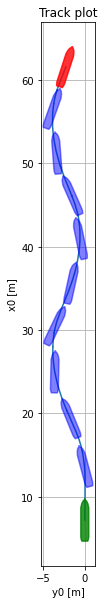

In [6]:
from src.visualization.plot import track_plot
fig,ax=plt.subplots()
fig.set_size_inches(10,10)
track_plot(df=df, lpp=meta_data.lpp, x_dataset='x0', y_dataset='y0',  psi_dataset='psi', beam=meta_data.beam, ax=ax);

## Yaw rate

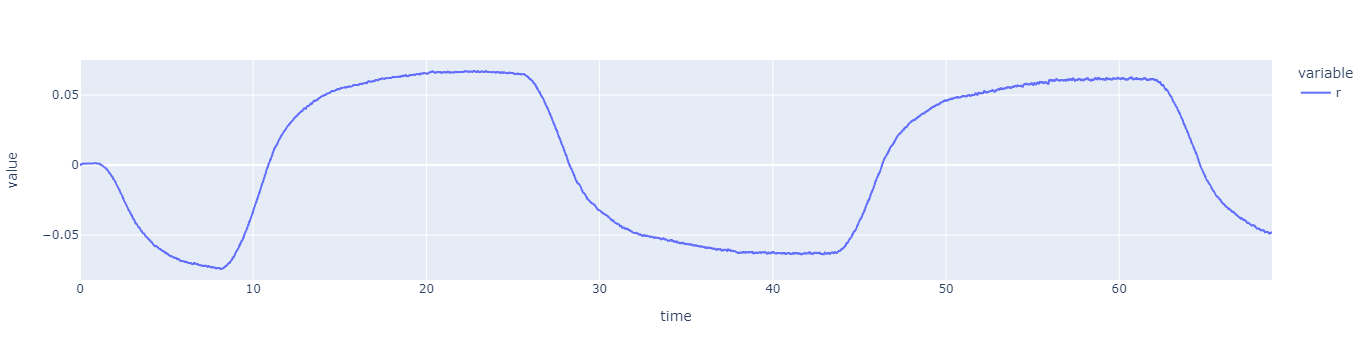

In [7]:
px.line(data_frame=df, y=['r'], width=1400, height=300,)

# Linear VMM

## N

In [8]:
Math(vlatex(eq.N_eq))

<IPython.core.display.Math object>

In [9]:
N_eq = eq.N_eq.copy()
N_eq = N_eq.subs([
    (x_G,0),  # Assuming or moving to CG=0
    (I_z,1),  # Removing inertia
    (eq.p.Nrdot,0),  # Removing added mass
])  

N_eq = sp.Eq(r.diff(), sp.solve(N_eq,r.diff())[0])  # Putting r1d on the LHS

In [10]:
Math(vlatex(N_eq))

<IPython.core.display.Math object>

In [11]:
diff_eq_N = regression.DiffEqToMatrix(ode=N_eq, label=r.diff(), base_features=[delta,u,v,r])

In [12]:
Math(vlatex(diff_eq_N.acceleration_equation))

<IPython.core.display.Math object>

In [13]:
Math(vlatex(diff_eq_N.acceleration_equation_x))

<IPython.core.display.Math object>

In [14]:
diff_eq_N.eq_beta

Eq(beta, Matrix([
[N_{\dot{u}}],
[N_{\dot{v}}],
[ N_{\delta}],
[      N_{r}],
[      N_{u}],
[      N_{v}]]))

In [15]:
Math(vlatex(diff_eq_N.eq_X))

<IPython.core.display.Math object>

In [16]:
diff_eq_N.X_lambda

<function _lambdifygenerated(delta, r, u, u1d, v, v1d)>

In [17]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
def show_pred(X,y,results):
    
    display(results.summary())
    
    X_ = X
    y_ = y
    y_pred = results.predict(X_)
    
    prstd, iv_l, iv_u = wls_prediction_std(results, exog=X_, alpha=0.05)
    #iv_l*=-1 
    #iv_u*=-1
    
    fig,ax=plt.subplots()
    ax.plot(X_.index,y_, label='Numerical gradient from model test')
    ax.plot(X_.index,y_pred, '--', label='OLS')
    ax.set_ylabel(r'$\ddot{\psi}$ $[rad/s^2]$')
    
    ax.fill_between(X_.index, y1=iv_l, y2=iv_u, zorder=-10, color='grey', alpha=0.5, label=r'5\% confidence')
    ax.legend();

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    r1d   R-squared (uncentered):                   0.947
Model:                            OLS   Adj. R-squared (uncentered):              0.947
Method:                 Least Squares   F-statistic:                          2.031e+04
Date:                Mon, 28 Jun 2021   Prob (F-statistic):                        0.00
Time:                        17:20:45   Log-Likelihood:                          31175.
No. Observations:                6883   AIC:                                 -6.234e+04
Df Residuals:                    6877   BIC:                                 -6.230e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Nu1d           0.2128      0.008     25.467      0.000       0.196       0.229
Nv1d          -0.5744      0.020    -29.381      0.000      -0.613      -0.536
Ndelta        -0.0368      0.001    -28.642      0.000      -0.039      -0.034
Nr            -0.1167      0.009    -12.598      0.000      -0.135      -0.099
Nu            -0.0015   4.93e-05    -30.354      0.000      -0.002      -0.001
Nv            -0.1045      0.005    -22.336      0.000      -0.114      -0.095
==============================================================================
Omnibus:                      278.451   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              220.941
Skew:                          -0.356   Prob(JB):                     1.05e-48
Kurtosis:                       2.486   Cond. No.                         556.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

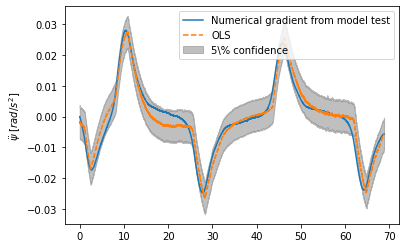

In [18]:
X = diff_eq_N.calculate_features(data=df)
y = diff_eq_N.calculate_label(y=df['r1d'])

model_N = sm.OLS(y,X)
results_N = model_N.fit()

show_pred(X=X,y=y,results=results_N)

## Y

In [19]:
Y_eq = eq.Y_eq.copy()
Y_eq = Y_eq.subs([
    (eq.p.Yvdot,1),  # Removing added mass
    (m,0),  # mass
    
])  

Y_eq = sp.Eq(v.diff(), sp.solve(Y_eq,v.diff())[0])  # Putting r1d on the LHS

In [20]:
Math(vlatex(Y_eq))

<IPython.core.display.Math object>

In [21]:
diff_eq_Y = regression.DiffEqToMatrix(ode=Y_eq, label=v.diff(), base_features=[delta,u,v,r])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    v1d   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          6.345e+05
Date:                Mon, 28 Jun 2021   Prob (F-statistic):                        0.00
Time:                        17:20:46   Log-Likelihood:                          34908.
No. Observations:                6883   AIC:                                 -6.980e+04
Df Residuals:                    6877   BIC:                                 -6.976e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Yr1d          -0.1942      0.007    -29.381      0.000      -0.207      -0.181
Yu1d           0.0553      0.005     10.971      0.000       0.045       0.065
Ydelta         0.0464      0.001     82.887      0.000       0.045       0.047
Yr             0.3234      0.004     85.076      0.000       0.316       0.331
Yu            -0.0007   2.94e-05    -23.279      0.000      -0.001      -0.001
Yv            -0.2265      0.001   -327.070      0.000      -0.228      -0.225
==============================================================================
Omnibus:                      205.025   Durbin-Watson:                   0.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              141.980
Skew:                          -0.241   Prob(JB):                     1.48e-31
Kurtosis:                       2.488   Cond. No.                         323.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

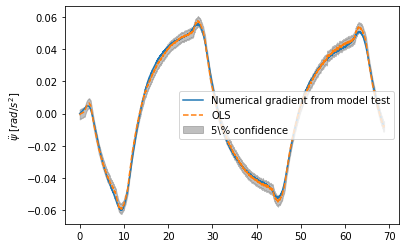

In [22]:
X = diff_eq_Y.calculate_features(data=df)
y = diff_eq_Y.calculate_label(y=df['v1d'])

model_Y = sm.OLS(y,X)
results_Y = model_Y.fit()

show_pred(X=X,y=y,results=results_Y)

## X

In [23]:
X_eq = eq.X_eq.copy()
X_eq = X_eq.subs([
    (eq.p.Xudot,1),  # Removing added mass
    (m,0),  # mass
    
])  

X_eq = sp.Eq(u.diff(), sp.solve(X_eq,u.diff())[0])  # Putting r1d on the LHS

In [24]:
Math(vlatex(X_eq))

<IPython.core.display.Math object>

In [25]:
diff_eq_X = regression.DiffEqToMatrix(ode=X_eq, label=u.diff(), base_features=[delta,u,v,r])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    u1d   R-squared (uncentered):                   0.453
Model:                            OLS   Adj. R-squared (uncentered):              0.453
Method:                 Least Squares   F-statistic:                              951.0
Date:                Mon, 28 Jun 2021   Prob (F-statistic):                        0.00
Time:                        17:20:47   Log-Likelihood:                          28962.
No. Observations:                6883   AIC:                                 -5.791e+04
Df Residuals:                    6877   BIC:                                 -5.787e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Xr1d           0.4049      0.016     25.467      0.000       0.374       0.436
Xv1d           0.3111      0.028     10.971      0.000       0.256       0.367
Xdelta         0.0069      0.002      3.673      0.000       0.003       0.011
Xr            -0.0351      0.013     -2.721      0.007      -0.060      -0.010
Xu             0.0037   5.69e-05     65.205      0.000       0.004       0.004
Xv             0.0404      0.007      6.064      0.000       0.027       0.053
==============================================================================
Omnibus:                     1012.136   Durbin-Watson:                   0.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              255.354
Skew:                          -0.122   Prob(JB):                     3.55e-56
Kurtosis:                       2.088   Cond. No.                         580.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

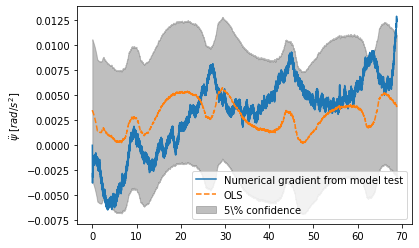

In [26]:
X = diff_eq_X.calculate_features(data=df)
y = diff_eq_X.calculate_label(y=df['u1d'])

model_X = sm.OLS(y,X)
results_X = model_X.fit()

show_pred(X=X,y=y,results=results_X)

In [27]:
results_summary_X = regression.results_summary_to_dataframe(results_X)
results_summary_Y = regression.results_summary_to_dataframe(results_Y)
results_summary_N = regression.results_summary_to_dataframe(results_N)

## Simulation

In [28]:
eqs = [diff_eq_X.acceleration_equation, diff_eq_Y.acceleration_equation, diff_eq_N.acceleration_equation]
solution = sp.solve(eqs, u.diff(), v.diff(), r.diff(), dict=True)

## Decouple the equations:
u1d_eq = sp.Eq(u.diff(), solution[0][u.diff()]) 
v1d_eq = sp.Eq(v.diff(), solution[0][v.diff()]) 
r1d_eq = sp.Eq(r.diff(), solution[0][r.diff()]) 

## Lambdify:
subs = {value:key for key,value in eq.p.items()}
u1d_lambda = lambdify(u1d_eq.subs(subs).rhs)
v1d_lambda = lambdify(v1d_eq.subs(subs).rhs)
r1d_lambda = lambdify(r1d_eq.subs(subs).rhs)

In [54]:
from scipy.spatial.transform import Rotation as R

def step(t, states, parameters, df_control):
    
    u,v,r,x0,y0,psi = states

    states_dict = {
        
        'u':u,
        'v':v,
        'r':r,
        
        'x0':x0,
        'y0':y0,
        'psi':psi,
        
        }
    
    inputs = dict(parameters)
    inputs.update(states_dict)
    
    index = np.argmin(np.abs(df_control.index-t))
    control = dict(df_control.iloc[index])
    inputs.update(control)
    
    inputs['U'] = np.sqrt(u**2 + v**2)  #Instantanious velocity
    
    u1d = run(function=u1d_lambda, inputs=inputs)
    v1d = run(function=v1d_lambda, inputs=inputs)
    r1d = run(function=r1d_lambda, inputs=inputs)
    
    
    rotation = R.from_euler('z', psi, degrees=False)
    w = 0
    velocities = rotation.apply([u,v,w])
    x01d = velocities[0]
    y01d = velocities[1]
    psi1d = r    

    dstates = [
        u1d,
        v1d,
        r1d,
        x01d,
        y01d,
        psi1d,
    ]    
    
    print(t)
    
    return dstates



In [55]:
parameters = dict(results_summary_X['coeff'])
parameters.update(dict(results_summary_Y['coeff']))
parameters.update(dict(results_summary_N['coeff']))


parameters['Nudot'] = 0
parameters['Yrdot'] = 0 
parameters['Nvdot'] = 0 
parameters['Yudot'] = 0
parameters['Xrdot'] = 0 
parameters['Xvdot'] = 0

states = ['u','v','r','x0','y0','psi']
states0 = [float(df[key].iloc[0]) for key in states]
df_control = df[['delta']]


In [56]:
u,v,r,x0,y0,psi = states0

states_dict = {
    
    'u':u,
    'v':v,
    'r':r,
    
    'x0':x0,
    'y0':y0,
    'psi':psi,
    
    }

inputs = dict(parameters)
inputs.update(states_dict)

index = 0
control = dict(df_control.iloc[index])
inputs.update(control)

inputs['U'] = np.sqrt(u**2 + v**2)  #Instantanious velocity

run(function=u1d_lambda, inputs=inputs)

-0.003500545443227344

In [57]:
run(function=v1d_lambda, inputs=inputs)

0.0005294441500663936

In [58]:
run(function=r1d_lambda, inputs=inputs)

-0.0013650761985653857

In [ ]:
## Simulate:
t = np.array(df.index)
t_span = [t[0],t[-1]]
solution = solve_ivp(fun=step, t_span=t_span, y0=states0, t_eval=t, args=(parameters, df_control))

0.0
0.009946110745668701
0.022157333276428104
0.033235999914642156
0.08862933310571242
0.0984770367841249
0.11078666638214052
0.11078666638214052
0.20129160205232244
0.2465440698874134
0.4728064090628682
0.5130308249162824
0.5633113447330501
0.5633113447330501
0.8941718307572712
1.0596020737693819
1.8867532888299348
2.0338023937295886
2.217613774854156
2.217613774854156
0.7658844029394547
0.867170932042657
1.3736035775586686
1.463636047872626
1.5761766357650733
1.5761766357650733
0.7361119232716403
0.8225122125409354
1.254513658887411
1.3313139160156733
1.427314237426001
1.427314237426001
0.692842919506859
0.7576087068937634
1.0814376438282853
1.139007232616645
1.2109692186020942
1.2109692186020942
0.6583504677197369
0.7058700292130804
0.9434678366797974
0.9857074468961027
1.0385069596664842
1.0385069596664842
1.133546082653171
1.1810656441465144
1.4186634516132315
1.4609030618295367
1.5137025745999182
1.5137025745999182
1.621054770587012
1.674730868580559
1.9431113585482938
1.99082344

In [ ]:
df_result = pd.DataFrame(data=solution.y.T, columns=states)
df_result.index=t[0:len(df_result)]

# First order Nomoto model for ship maneuvering dynamics
The first order Nomoto model can be written as:

In [ ]:
K, delta, T_1, T_2 = sp.symbols('K delta T_1 T_2')
r = dynamicsymbols('r')

eq_nomoto = sp.Eq(-K*delta,
                 r + T_1*r.diff() + T_2*r.diff().diff())
Math(vlatex(eq_nomoto))

where $r$ is yaw rate with its time derivatives and $\delta$ is the rudder angle. $K$, $T_{1}$
 and $T_{1}$ are the coefficients describing the hydrodynamics of the ship.
 
For slow manoeuvres this equation can be further simplified by removing the $\ddot{r}$ term:

In [ ]:
eq_nomoto_simple = eq_nomoto.subs(r.diff().diff(),0)
Math(vlatex(eq_nomoto_simple))

In [ ]:
eq_r1 = sp.Eq(r.diff(),
             sp.solve(eq_nomoto_simple, r.diff())[0])
r1d_lambda = lambdify(sp.solve(eq_nomoto_simple, r.diff())[0])
Math(vlatex(eq_r1))


In [ ]:
def nomoto(t,states,df_control,params):
    """
    Simulation model for heading and yaw rate using Nomoto with only K and T_1
    """
    # states:
    psi = states[0]
    r = states[1]
    
    index = df_control.index.get_loc(t, method='nearest')
    delta = float(df_control['delta'].iloc[index])
    r1d_ = r1d_lambda(K=params['K'], T_1=params['T_1'], delta=delta, r=r)
    d_states_dt = np.array([r,r1d_])
    return d_states_dt

## Simulate a pull out manoeuvre
Simulating a simple pull out manoeuvre:

In [ ]:
params = {
    'K' :  0.1,
    'T_1' : 10,
}

states_0 = np.array([df.iloc[0]['psi'],df.iloc[0]['r']])

df_control = df.copy()
df_control.index = df_control.index.total_seconds()
t = df_control.index

sol = solve_ivp(fun = nomoto,t_span=[t[0],t[-1]],t_eval=t, y0 = states_0, args=(df_control,params))
psi = sol.y[0,:]
r = sol.y[1,:]

fig,ax=plt.subplots()
df_control['psi_deg'] = np.rad2deg(df_control['psi'])
df_control.plot(y='psi_deg', label='model test', ax=ax)
ax.plot(t,np.rad2deg(psi), label='simulation');
ax.grid(True)
ax.set_title('Resimulation with Nomoto model')
ax.set_ylabel('$\psi$ [deg]')
ax.set_xlabel('time [s]');
ax.legend()


## Regress nomoto parameters

In [ ]:
eq_r1

In [ ]:
import sympy.physics.mechanics as me

me.find_dynamicsymbols(eq_r1)

In [ ]:
eq_r1.rhs

In [ ]:
y = df_control['r1d']
X = df_control[['delta','r']] 

#y = df_control['r1d_numerical']
#X = df_control[['delta','r_numerical']] 
#X.rename(columns={'r_numerical': 'r'}, inplace=True)

model = sm.OLS(y,X)
results = model.fit()
results.summary()

In [ ]:
r1d_pred = results.predict(X)
X_ = X.iloc[::100, :]
prstd, iv_l, iv_u = wls_prediction_std(results, exog=X_, alpha=0.05)

fig,ax=plt.subplots()
ax.plot(t,y, label=r'$\dot{r}$')
ax.plot(t,r1d_pred, label=r'$\dot{r}_{pred}$')

ax.plot(X_.index,iv_l, 'k--')
ax.plot(X_.index,iv_u, 'k--')
ax.legend()

In [ ]:
params['T_1'] = -1/results.params['r']
params['K'] = -results.params['delta']*params['T_1']

In [ ]:
states_0 = np.array([df.iloc[0]['psi'],df.iloc[0]['r']])

df_control = df.copy()

df_control.index = df_control.index.total_seconds()
t = df_control.index

sol = solve_ivp(fun = nomoto,t_span=[t[0],t[-1]],t_eval=t, y0 = states_0, args=(df_control,params))
psi = sol.y[0,:]
r = sol.y[1,:]

fig,ax=plt.subplots()
df_control['psi_deg'] = np.rad2deg(df_control['psi'])
df_control.plot(y='psi_deg', label='model test', ax=ax)

df_control['-delta_deg'] = -np.rad2deg(df_control['delta'])
df_control.plot(y='-delta_deg', label=r'$-\delta$', ax=ax)

ax.plot(t,np.rad2deg(psi), label='simulation');
ax.grid(True)
ax.set_title('Resimulation with Nomoto model')
ax.set_ylabel('$\psi$ [deg]')
ax.set_xlabel('time [s]');
ax.legend();
